# Подготовка данных

In [25]:
import pandas as pd
import numpy as np

# basic preprocessing
col_types = {u'id': np.int, u'query': np.str, u'product_title': np.str,
             u'product_description': np.str, u'median_relevance': np.int, u'relevance_variance': np.float}
srt_lowerizer = lambda s: s.lower()

convertors = {u'query': srt_lowerizer, u'product_title': srt_lowerizer, u'product_description': srt_lowerizer}

df = pd.concat([pd.read_csv('train.csv', dtype=col_types, converters=convertors, index_col=u'id'), \
                pd.read_csv('test.csv',  dtype=col_types, converters=convertors, index_col=u'id')])

Статистика оценок

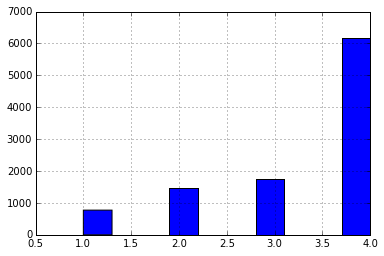

In [93]:
%matplotlib inline
df[~df.median_relevance.isnull()].median_relevance.hist()

Загружаем простейшие статистики 
 - длины текстов
 - наличие описания

In [26]:
df['q_len'] = df['query'].apply(lambda s: len(s))
df['t_len'] = df['product_title'].apply(lambda s: len(s))
df['d_len'] = df['product_description'].apply(lambda s: len(s))
df['d_loglen'] = df['product_description'].apply(lambda s: np.log(len(s) + 1))
df['d_exist'] = df['product_description'].apply(lambda s: 1.0 if len(s) > 0 else 0.0)

- Очищаем тексты от html разметки<br>
- убираем все нелатинские символы<br>
- делим описание на клаузы<br>
- нормализуем, убираем стопслова

In [47]:
from bs4 import BeautifulSoup
import re
nonlatin = re.compile (ur'[^a-zA-Z0-9 ]')
space =  re.compile (ur'\s+')

df['query'] = df['query'].apply (lambda x: space.sub(u' ', x))
df['query'] = df['query'].apply (lambda x: nonlatin.sub(u'', x))

df['product_title'] = df['product_title'].apply (lambda x: BeautifulSoup(x).getText())
df['product_title'] = df['product_title'].apply (lambda x: space.sub(u' ', x))
df['product_title'] = df['product_title'].apply (lambda x: nonlatin.sub(u'', x))


df['product_description'] = df['product_description'].apply (lambda x: BeautifulSoup(x).getText())
df['product_description_clauses'] = df['product_description'].apply (lambda x: re.split('[\n,\.!?;]', x))
df['product_description_clauses'] = df['product_description_clauses'].apply (lambda x: map (lambda y: space.sub(u' ', y), x))
df['product_description_clauses'] = df['product_description_clauses'].apply (lambda x: map (lambda y: nonlatin.sub(u'', y), x))
df['product_description_clauses'] = df['product_description_clauses'].apply (lambda x: map (lambda y: y.strip(), x))
df['product_description_clauses'] = df['product_description_clauses'].apply (lambda x: filter (lambda y:len(y)>0,x))


df['product_description'] = df['product_description'].apply (lambda x: space.sub(u' ', x))
df['product_description'] = df['product_description'].apply (lambda x: nonlatin.sub(u'', x))

In [48]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stopwords_set = set(stopwords.words('english') + ['http','www','img','border','0','1','2','3','4','5','6','7','8','9'])

stemmer = PorterStemmer()

def remove_stopwords_and_stem (s):
    return ' '.join ([stemmer.stem (w) for w in s.split(' ') if w not in stopwords_set])

df['product_description'] = df['product_description'].apply(remove_stopwords_and_stem)
df['product_title'] = df['product_title'].apply(remove_stopwords_and_stem)
df['query'] = df['query'].apply(remove_stopwords_and_stem)
df['product_description_clauses'] = df['product_description_clauses'].apply (lambda x: map(remove_stopwords_and_stem ,x))


Следующие фичи - количество слов, количество клауз

In [49]:
df['q_words'] = df['query'].apply (lambda x: len(x.split(' ')))
df['d_words'] = df['product_description'].apply (lambda x: len(x.split(' ')))
df['t_words'] = df['product_title'].apply (lambda x: len(x.split(' ')))
df['d_clauses'] = df['product_description_clauses'].apply (lambda x: len(x))

## Меры близости запроса и заголовка / описания
- число слов запроса в заголовке / описании

In [56]:
def a_in_b_cnt (a_set, b_set):
    ab_intersection = len(a_set.intersection(b_set))
    return 1. * ab_intersection / len(b_set)

df["q_in_t"] = df.apply(lambda x: a_in_b_cnt(set(x['query'].split(' ')), 
                                             set(x['product_title'].split(' '))), axis=1)

df["q_in_d"] = df.apply(lambda x: a_in_b_cnt(set(x['query'].split(' ')), 
                                             set(x['product_description'].split(' '))), axis=1)

- мера жоккара между запросом и заголовком / описанием


In [57]:
def jaccard (a_set, b_set):
    ab_intersection = len(a_set.intersection(b_set))
    return 1. * ab_intersection / (len(a_set) + len(b_set) - ab_intersection)


df["q_jac_t"] = df.apply(lambda x: jaccard(set(x['query'].split(' ')), 
                                           set(x['product_title'].split(' '))), axis=1)

df["q_jac_d"] = df.apply(lambda x: jaccard(set(x['query'].split(' ')), 
                                           set(x['product_description'].split(' '))), axis=1)

- перекрытие с запросом / описанием

In [58]:
def overlap (a_set, b_set):
    ab_intersection = len(a_set.intersection(b_set))
    return 1. * ab_intersection / min(len(a_set),len(b_set))


df["q_over_t"] = df.apply(lambda x: overlap(set(x['query'].split(' ')), 
                                            set(x['product_title'].split(' '))), axis=1)

df["q_over_d"] = df.apply(lambda x: overlap(set(x['query'].split(' ')), 
                                            set(x['product_description'].split(' '))), axis=1)

- косинусная близость в пространстве топиков

(расскладывать на топики можно по разному. <br>
Сохраняем результаты для 1- и 2-граммов, <br>
размерностей пространства топиков от 100 до 500)

In [21]:
def cos_sim(a_ar, b_ar):
    v = (a_ar*b_ar).sum(axis=1)/np.sqrt((a_ar**2).sum(axis=1) * (b_ar**2).sum(axis=1))
    v[np.isnan(v)] = 0
    return v

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

ngram_range_max_grid = [1, 2]
svd_n_components_grid = [100, 200, 300, 400, 500]

for ngram_range_max in ngram_range_max_grid:
    for svd_n_components in svd_n_components_grid:
        print '%i - %i' % (ngram_range_max, svd_n_components)
        tfv = TfidfVectorizer(analyzer='word', 
                              ngram_range=(1, ngram_range_max),
                              sublinear_tf=1, 
                              use_idf=1, 
                              smooth_idf=1,
                              token_pattern=r'\w{1,}', 
                              min_df=3)
        
        all_texts = list([t for t in df['query'].values.tolist() if len(t) > 0])
        all_texts.extend([t for t in df['product_title'].values.tolist() if len(t) > 0])
        
        tfv = tfv.fit(all_texts)
        tf_idf_all_texts = tfv.transform(all_texts)
        svd = TruncatedSVD(n_components=svd_n_components)
        svd = svd.fit(tf_idf_all_texts)

        q_nss_tfidf_svd = svd.transform(tfv.transform(df['query'].values.tolist()))
        t_nss_tfidf_svd = svd.transform(tfv.transform(df['product_title'].values.tolist()))

        df['cos_qt_tfidf%i_svd%i' % (ngram_range_max, svd_n_components)] = cos_sim(q_nss_tfidf_svd, t_nss_tfidf_svd)
        df['cos_qt_tfidf%i_svd%i' % (ngram_range_max, svd_n_components)] = \
            df['cos_qt_tfidf%i_svd%i' % (ngram_range_max, svd_n_components)].fillna(0)
       
        tfv = TfidfVectorizer(analyzer='word', ngram_range=(1, ngram_range_max),
                              sublinear_tf=1, use_idf=1, smooth_idf=1,
                              token_pattern=r'\w{1,}', min_df=3)

        all_texts = list([t for t in df['query'].values.tolist() if len(t) > 0])
        all_texts.extend([t for t in df['product_description'].values.tolist() if len(t) > 0])
        
        tfv = tfv.fit(all_texts)
        tf_idf_all_texts = tfv.transform(all_texts)
        
        svd = TruncatedSVD(n_components=svd_n_components)
        svd = svd.fit(tf_idf_all_texts)

        q_nss_tfidf_svd = svd.transform(tfv.transform(df['query'].values.tolist()))
        d_nss_tfidf_svd = svd.transform(tfv.transform(df['product_description'].values.tolist()))
 
        df['cos_qd_tfidf%i_svd%i' % (ngram_range_max, svd_n_components)] = cos_sim(q_nss_tfidf_svd, d_nss_tfidf_svd)
        df['cos_qd_tfidf%i_svd%i' % (ngram_range_max, svd_n_components)] = \
            df['cos_qd_tfidf%i_svd%i' % (ngram_range_max, svd_n_components)].fillna(0)
 

        ds_nss_tfidf_svd_cos = []
        for i in range(df.shape[0]):
            if len(df['product_description_clauses'].values[i]) == 0:
                ds_nss_tfidf_svd_cos.append(np.array([0]))
                continue
                
            tmp_q = np.repeat(q_nss_tfidf_svd[i, :], 
                              len(df['product_description_clauses'].values[i]))\
                      .reshape((len(df['product_description_clauses'].values[i]), 
                                q_nss_tfidf_svd.shape[1]), 
                               order='F')
            tmp_d = svd.transform(tfv.transform(df['product_description_clauses'].values[i]))
            
            ds_nss_tfidf_svd_cos.append(cos_sim(tmp_q, tmp_d))
 
        df['cos_min_qd_tfidf%i_svd%i' % (ngram_range_max, svd_n_components)] = \
            map(lambda v: np.min(v), ds_nss_tfidf_svd_cos)
        df['cos_max_qd_tfidf%i_svd%i' % (ngram_range_max, svd_n_components)] = \
            map(lambda v: np.max(v), ds_nss_tfidf_svd_cos)
        df['cos_mean_qd_tfidf%i_svd%i' % (ngram_range_max, svd_n_components)] = \
            map(lambda v: np.mean(v), ds_nss_tfidf_svd_cos)
        df['cos_median_qd_tfidf%i_svd%i' % (ngram_range_max, svd_n_components)] = \
            map(lambda v: np.median(v), ds_nss_tfidf_svd_cos)

- метрика качества ранжирования okapi bm25 (тоже для N-граммов разной длинны)

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

# Okapi BM25
class OkapiBM25:
    vectorizer = None
    documents_cnt = 1
    word_doc_freq = {}
    k = 1.5
    b = 0.75
    avgdl = 0
   
    def __init__(self, max_n_gram=2, k=1.5, b=0.75):
        self.vectorizer = CountVectorizer(analyzer='word', 
                                          ngram_range=(1, max_n_gram), 
                                          stop_words=None)
        self.k = k        
        self.b = b
   
    def fit(self, X):
        self.documents_cnt = X.shape[0]
        X = self.vectorizer.fit_transform(X)
        self.avgdl = 1. * X.sum() / self.documents_cnt
        
        self.word_doc_freq = dict(
            zip(map(lambda p: p[0], 
                    sorted(self.vectorizer.vocabulary_.items(), 
                           key=lambda p: p[1])),
                np.array(X.sum(axis=0), 
                         dtype=np.int).flatten().tolist()))
           
    def idf(self, w):
        n = self.word_doc_freq[w] if w in self.word_doc_freq else 0
        return np.log((self.documents_cnt - n + 0.5)/(n + 0.5))
   
    def f(self, w, d):
        return sum(map(lambda x: 1 if x == w else 0, d.split()))
   
    def score_word(self, w, d):
        fqd = self.f(w, d)
        return self.idf(w) * (fqd * (self.k + 1))/(fqd + self.k*(1 - self.b + self.b*(len(d.split()))/self.avgdl))
   
    def score_query(self, q, d):
        return sum(map(lambda w: self.score_word(w, d), q.split()))

In [ ]:
ngram_range_max_grid = range(1, 4)
for ngram_range_max in ngram_range_max_grid:
    print ngram_range_max
   
    obm25 = OkapiBM25(max_n_gram=ngram_range_max)
    obm25.fit(df['product_title'].values)
    df['obm25_%i_qt' % ngram_range_max] = \
        map(lambda p: obm25.score_query(p[0], p[1]), zip(df['query'].values, df['product_title'].values))
   
    obm25 = OkapiBM25(max_n_gram=ngram_range_max)
    obm25.fit(df['product_description'].values)
    df['obm25_%i_qd' % ngram_range_max] = \
        map(lambda p: obm25.score_query(p[0], p[1]), zip(df['query'].values, df['product_description'].values))
   
    sent_scores = map(lambda p: np.array(map(lambda d: obm25.score_query(p[0], d), p[1])),
                      zip(df['query'].values, df['product_description_clauses'].values))
   
    df['obm25_%i_min_qd' % ngram_range_max] = map(lambda v: np.min(v) if len(v) > 0 else 0, sent_scores)
    df['obm25_%i_max_qd' % ngram_range_max] = map(lambda v: np.max(v) if len(v) > 0 else 0, sent_scores)
    df['obm25_%i_mean_qd' % ngram_range_max] = map(lambda v: np.mean(v) if len(v) > 0 else 0, sent_scores)
    df['obm25_%i_median_qd' % ngram_range_max] = map(lambda v: np.median(v) if len(v) > 0 else 0, sent_scores)

- сходство через редакторское расстояние (для поиска опечаток)

In [63]:
from difflib import SequenceMatcher

def editorDistance (query, text, threshold=0.5):
    query_tokens = query.split(" ")
    text_tokens = text.split(" ")
    distance = [[SequenceMatcher (None, qt, tt).ratio() 
                 for tt in text_tokens] 
                 for qt in query_tokens] 
    distance = map (lambda x: max(x), distance)
    distance = map (lambda x: 0 if x<threshold else x, distance)
    return float(sum(distance))/len(query_tokens)
    
df['ed_q_to_t'] = df.apply (lambda x: editorDistance(x['query'],x['product_title']), axis = 1)
df['ed_q_to_d'] = df.apply (lambda x: editorDistance(x['query'],x['product_description']), axis = 1)

## Кластеризация запросов
в обучающей и в тестовой выборке присутствуют одни и те же запросы<br>
поэтому можно разделить запросы на группы (кластеризовать) по <br>
распределению  ответов на запросы по оценкам

In [65]:
queries_relevance_stat = df[~df.median_relevance.isnull()][['query','median_relevance']]\
                            .groupby (['query','median_relevance'])["query"].count()

queries_stat = df[~df.median_relevance.isnull()].groupby(['query'])['query'].count()
queries_distribution = queries_relevance_stat.divide(queries_stat, level=0).unstack().fillna(0)

# Используем алгоритм кластеризации MeanShift
from sklearn.cluster import MeanShift
clusterer = MeanShift(bandwidth=0.125)
labels    = clusterer.fit_predict(queries_distribution.values)

query2cluster = dict (zip (list(queries_distribution.index), list(labels)))
df ['query_cluster'] = df['query'].apply(lambda x: query2cluster[x])

По медиане и дисперсии можно определить, какие оценки выставлялись ассесорами.<br>
Используем оценки и их доли для более точной кластеризации

In [80]:
# Кластеризуем запросы с разложением по релевантности
restored_relevance = pd.read_csv('restored_relevance_train.csv', dtype=col_types)

query_with_relevance = df [~df.median_relevance.isnull()]\
                            .reset_index()\
                            .merge (restored_relevance, on="id")\
                            [["query", 'relevance', 'weight']]

queries_relevance_stat = query_with_relevance.groupby (['query','relevance'])["weight"].sum()
queries_stat = query_with_relevance.groupby (['query'])["weight"].sum()

queries_distribution = queries_relevance_stat.divide(queries_stat, level=0).unstack().fillna(0)

from sklearn.cluster import MeanShift
clusterer = MeanShift(bandwidth=0.125)
labels    = clusterer.fit_predict(queries_distribution.values)

query2cluster = dict (zip (list(queries_distribution.index), list(labels)))
df ['query_rel_cluster'] = df['query'].apply(lambda x: query2cluster[x])

## Сохранение результатов

In [83]:
df[~df.median_relevance.isnull()].to_csv("clean_train.csv")
df[df.median_relevance.isnull()].drop (['median_relevance','relevance_variance'], axis=1).to_csv ("clean_test.csv")